# **STYLE TRANSFER**

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adityaprakash04
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:22<00:00, 18.0MB/s]


In [9]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19

In [10]:
import os
import cv2
import numpy as np

# Path to the dataset directory
dataset_dir = '/content/animefacedataset/images'


# Initialize lists to store images and labels
images = []
labels = []
i=0

# Iterate through each image file
for filename in os.listdir(dataset_dir[0:5000]):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(dataset_dir, filename))

    # Resize the image to a desired size (e.g., 128x128)
    image = cv2.resize(image, (512, 512,))

    # Append the image to the images list
    images.append(image)
    i+=1
    if i == 5000:
      break

# Convert the lists to NumPy arrays
x_train = np.array(images)

In [11]:
VGG_LAYERS = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1', 'block3_conv2',
    'block3_conv3', 'block3_conv4',
    'block4_conv1',
]

class WaveLet_pooling(tf.keras.layers.Layer):
    def __init__(self, name):
        super(WaveLet_pooling, self).__init__(name=name)
        # Calculation of Haar Wavelets.
        sqrt_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.constant([[1, 1]], dtype=tf.float32) / sqrt_2
        H = tf.constant([[-1,1]], dtype=tf.float32) / sqrt_2

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        # self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        # self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))

    def call(self, inputs):
        LL, HH = self.repeat_filters(inputs.shape[-1]) #   YAHA PAR CHANGE!!!
        return [
            tf.nn.conv2d(inputs, LL, strides=[1, 2, 2, 1], padding='SAME'),
            #tf.nn.conv2d(inputs, LH, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d(inputs, HL, strides=[1, 2, 2, 1], padding='SAME'),                        # YAHA PAR CHANGE!!!
            tf.nn.conv2d(inputs, HH, strides=[1, 2, 2, 1], padding='SAME')
        ]

    def compute_output_shape(self, input_shape):
        shape = (
            input_shape[0], input_shape[1] // 2, input_shape[2] // 2, input_shape[3]
        )
        return [shape, shape, shape, shape]

    def repeat_filters(self, repeats):
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),                      # YAHA PAR CHANGE
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0))
        ]


class WaveLet_unpooling(tf.keras.layers.Layer):
    def __init__(self, name):
        super(WaveLet_unpooling, self).__init__()
        self._name = name
        # Calculation of Haar Wavelets.
        sqrt_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.constant([[1, 1]], dtype=tf.float32)/sqrt_2
        H = tf.constant([[-1,1]], dtype=tf.float32)/sqrt_2

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        # self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        # self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))        # YAHA PAR CHANGE

    def call(self, inputs):
        LL_in, HH_in, tensor_in = inputs                    # YAHA PAR CHANGE !!
        LL, HH = self.repeat_filters(LL_in.shape[-1])
        out_shape = tf.shape(tensor_in)
        return tf.concat([
            tf.nn.conv2d_transpose(LL_in, LL, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d_transpose(LH_in, LH, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d_transpose(HL_in, HL, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            tf.nn.conv2d_transpose(HH_in, HH, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),       # YAHA PAR CHANGHE
            tensor_in,
        ], axis=-1)

    def compute_output_shape(self, input_shape):
        _ip_shape = input_shape[0]
        shape = (
            _ip_shape[0],
            _ip_shape[1] * 2,
            _ip_shape[2] * 2,
            sum(ips[3] for ips in input_shape)
        )
        return shape

    def repeat_filters(self, repeats):
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),          # YAHA PAR CHANGE
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0)),
        ]

class Whitening_Coloring(tf.keras.layers.Layer):
      def __init__(self, alpha=1.0):
        super(Whitening_Coloring, self).__init__()
        self.alpha = alpha

      def call(self, inputs):
        content, style = inputs
        eps = 1e-8
        alpha = self.alpha

        content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
        style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

        Cc, Hc, Wc = content_t.shape
        Cs, Hs, Ws = style_t.shape

        content_flat = tf.reshape(content_t, (Cc, Hc * Wc))
        style_flat = tf.reshape(style_t, (Cs, Hs * Ws))

        mc = tf.reduce_mean(content_flat, axis=1, keepdims=True)
        fc = content_flat - mc
        fcfc = tf.linalg.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc * Wc, tf.float32) - 1.) + tf.eye(Cc) * eps

        ms = tf.reduce_mean(style_flat, axis=1, keepdims=True)
        fs = style_flat - ms
        fsfs = tf.linalg.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs * Ws, tf.float32) - 1.) + tf.eye(Cs) * eps

        with tf.device('/cpu:0'):
          Sc, Uc, _ = tf.linalg.svd(fcfc)
          Ss, Us, _ = tf.linalg.svd(fsfs)

        k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.float32)).numpy()
        k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.float32)).numpy()

        k_c, k_s = int(k_c), int(k_s)

        Dc = tf.linalg.diag(tf.pow(Sc[:k_c], -0.5))
        fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:, : k_c], Dc), Uc[:, : k_c], transpose_b=True), fc)

        Ds = tf.linalg.diag(tf.pow(Ss[:k_s], 0.5))
        fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:, : k_s], Ds), Us[:, : k_s], transpose_b=True), fc_hat)

        fcs_hat = fcs_hat + ms

        blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)

        blended = tf.reshape(blended, (Cc, Hc, Wc))

        blended = tf.expand_dims(tf.transpose(blended, (1, 2, 0)), 0)

        return blended


In [12]:
class WCT2:
    def __init__(
        self,
        lr=1e-3,
        gram_loss_weight=1.0,
        checkpoint_path="checkpoints/wtc2.h5",
    ):
        self.lr = lr
        self.img_shape = (None, None, 3)
        self.checkpoint_path = checkpoint_path

        img = Input(self.img_shape)
        self.wct = self.build_wct_model()
        self.wct.compile(optimizer=Adam(self.lr), loss=["mse", self.gram_loss])

        self.init_transfer_sequence()

    def gram_loss(self, img, gen_img):
        feat_gens = self.encoder(gen_img)
        feats = self.encoder(img)

        gram_gen = [gram_matrix(f) for f in feat_gens]
        gram_in = [gram_matrix(f) for f in feats]
        num_style_layers = len(gram_gen)
        loss_list = [
            K.mean(K.square(gram_gen[i] - gram_in[i]))
            for i in range(num_style_layers)
        ]

        gram_loss = tf.reduce_sum(loss_list) / num_style_layers
        return gram_loss

    def conv_block(self, x, filters, kernel_size, activation='relu', name=""):
        x = Conv2D(
            filters, kernel_size=kernel_size, strides=1,
            padding='same', activation=activation, name=name)(x)

        return x

    def copy_layer(self, x, kernel_size, model, layer, name):
        """
        Need to copy layer for unique name
        """
        origin_layer = model.get_layer(layer)
        filters = origin_layer.output_shape[-1]
        return self.conv_block(x, filters, kernel_size,
                               name=origin_layer.name + name)

    def build_wct_model(self):
        img = Input(self.img_shape, name='in_img')
        kernel_size = 3
        skips = []

        vgg_model = VGG19(include_top=False,
                          weights='imagenet',
                          input_tensor=Input(self.img_shape),
                          input_shape=self.img_shape)

        vgg_model.trainable = False
        for layer in vgg_model.layers:
            layer.trainable = False

        vgg_output = [
            vgg_model.get_layer(f'block{i}_conv1').get_output_at(0)
            for i in {1, 2, 3, 4}
        ]

        self.encoder = Model(inputs=vgg_model.inputs,
                             outputs=vgg_output,
                             name='encoder')

        # ======= Encoder ======= #
        id_ = 0
        x = self.copy_layer(img, kernel_size, vgg_model,
                            VGG_LAYERS[0], name='_encode')
        for layer in VGG_LAYERS[1:]:
            x = self.copy_layer(x, kernel_size, vgg_model, layer, name='_encode')
            if layer in {'block1_conv2', 'block2_conv2', 'block3_conv4'}:
                to_append = [x]
                x, hh = WaveLet_pooling('wave_let_pooling_{}'.format(id_))(x)                                                  # YAHA PAR CHANGE !!
                to_append += [hh]                                                                                                   # YAHA PAR CHANGE !!
                skips.append(to_append)
                id_ += 1

        # ======= Decoder ======= #
        skip_id = 2
        for layer in VGG_LAYERS[::-1][:-1]:
            filters = vgg_model.get_layer(layer).output_shape[-1]
            name = layer + "_decode"
            if layer in {'block4_conv1', 'block3_conv1', 'block2_conv1'}:
                x = self.conv_block(x, filters // 2, kernel_size, name=name)
                original, lh = skips[skip_id]                                                                                                     # YAHA PAR CHANGE!!!
                x = WaveLet_unpooling('wave_let_unpooling_{}'.format(skip_id))([x, lh, original])                                             # YAHA PAR CHANGE!!
                skip_id -= 1
            else:
                x = self.conv_block(x, filters, kernel_size, name=name)

        out = self.conv_block(x, 3, kernel_size, 'linear', name="output")

        wct = Model(inputs=img, outputs=out, name='wct')

        for layer in wct.layers:
            # dont train waveletpooling layers
            if "_encode" in layer.name:
                name = layer.name.replace("_encode", "")
                layer.set_weights(vgg_model.get_layer(name).get_weights())
                layer.trainable = False

        return wct

    def get_callbacks(self):
        return [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=self.checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.1, patience=2, verbose=1,
                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
            )
        ]

    def train(self, train_dat, epochs, batch_size, validation_split = 0.2):
      train_data = tf.data.Dataset.from_tensor_slices((train_dat, train_dat))
      train_data = train_data.batch(batch_size)

      num_validation_samples = int(validation_split * len(train_dat))
      validation_data = train_data.take(num_validation_samples)
      train_data = train_data.skip(num_validation_samples)

      checkpoint_path = "./style_ckpt/model_weights.ckpt"
      checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

      self.history = self.wct.fit(
        train_data,
        epochs=epochs,
        validation_data = validation_data,
        callbacks = [checkpoint]

      )

    def plot_history(self):
        plt.plot(self.history['loss'], label='train loss')
        plt.plot(self.history['val_loss'], label='val loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Segmentation model')
        plt.legend()
        plt.show()


    def transfer(self, content_img, style_img, alpha=1.0):
        # ===== Encode ===== #
        # step 1.
        content_feat, style_feat = self.en_1([content_img]), self.en_1([style_img])
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 2.
        content_feat, c_skips_1 = self.pool_1([content_feat])
        style_feat, s_skips_1 = self.pool_1([style_feat])
        c_skips_1 = [Whitening_Coloring(alpha)([c_skips_1[i], s_skips_1[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 3.
        content_feat, c_skips_2 = self.pool_2([content_feat])
        style_feat, s_skips_2 = self.pool_2([style_feat])
        c_skips_2 = [Whitening_Coloring(alpha)([c_skips_2[i], s_skips_2[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 4.
        content_feat, c_skips_3 = self.pool_3([content_feat])
        style_feat, s_skips_3 = self.pool_3([style_feat])
        c_skips_3 = [Whitening_Coloring(alpha)([c_skips_3[i], s_skips_3[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])

        # ===== Decode ===== #
        # step 1.
        content_feat, style_feat = self.de_1([content_feat]), self.de_1([style_feat])
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 2.
        content_feat = self.unpool_1([content_feat] + c_skips_3)
        style_feat = self.unpool_1([style_feat] + s_skips_3)
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        content_feat = self.de_2([content_feat])
        style_feat = self.de_2([style_feat])
        # step 3.
        content_feat = self.unpool_2([content_feat] + c_skips_2)
        style_feat = self.unpool_2([style_feat] + s_skips_2)
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        content_feat = self.de_3([content_feat])
        style_feat = self.de_3([style_feat])

        content_feat = self.unpool_3([content_feat] + c_skips_1)
        style_feat = self.unpool_3([style_feat] + s_skips_1)

        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])

        output = self.final([content_feat])
        output = output.numpy()

        return output.clip(min=0, max=255.0)

    def init_transfer_sequence(self):
        # ===== encoder layers ===== #
        self.en_1 = get_predict_function(self.wct, ['in_img', 'block1_conv1_encode'], name='en_1')

        self.pool_1 = get_predict_function(
            self.wct,
            ['block1_conv2_encode', 'wave_let_pooling_0', 'block2_conv1_encode'],
            name='pool_1')

        self.pool_2 = get_predict_function(
            self.wct,
            ['block2_conv2_encode', 'wave_let_pooling_1', 'block3_conv1_encode'],
            name='pool_2')

        self.pool_3 = get_predict_function(
            self.wct,
            [
                'block3_conv2_encode', 'block3_conv3_encode',
                'block3_conv4_encode',
                'wave_let_pooling_2', 'block4_conv1_encode'
            ],
            name='pool_3')

        # ===== decoder layers ===== #
        self.de_1 = get_predict_function(self.wct, ['block4_conv1_decode'], name='de_1')

        self.unpool_1 = get_predict_function(
            self.wct,
            [
                'wave_let_unpooling_2', 'block3_conv4_decode',
                'block3_conv3_decode', 'block3_conv2_decode'
            ],
            name='unpool_1')

        self.de_2 = get_predict_function(self.wct, ['block3_conv1_decode'], name='de_2')

        self.unpool_2 = get_predict_function(
            self.wct,
            ['wave_let_unpooling_1', 'block2_conv2_decode'],
            name='unpool_2')

        self.de_3 = get_predict_function(self.wct, ['block2_conv1_decode'], name='de_3')

        self.unpool_3 = get_predict_function(
            self.wct,
            ['wave_let_unpooling_0', 'block1_conv2_decode'],
            name='unpool_3')

        self.final = get_predict_function(self.wct, ['output'], name='final')


In [13]:

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

def _get_output(x, layer):
    if "_pooling" in layer.name:
        # return 4 outputs
        ll, hh = layer(x)   # YAHA PAR CHANGE !!
        return ll, [hh, x]  # YAHA PAR CHANGE !!
    return layer(x), None

def _copy_input(layer):
    # :1 to remove batch_size
    if hasattr(layer, 'input_shape'):
        ip_shape = layer.input_shape[1:]
    else:
        ip_shape = layer.shape[1:]
    return tf.keras.layers.Input(shape=ip_shape)

def get_predict_function(model, layers, name):
    skips_out = None

    if layers[0] == 'in_img':
        ip = model.get_layer(layers[0]).input
        start = 1
    elif 'unpooling' in layers[0]:
        # multi inputs
        ip = [
            _copy_input(l) for l in model.get_layer(layers[0]).input
        ]
        start = 0
    else:
        ip = _copy_input(model.get_layer(layers[0]))
        start = 0

    x, skips = _get_output(ip, model.get_layer(layers[start]))

    if skips is not None:
        skips_out = skips

    for layer in layers[start + 1:]:
        x, skips = _get_output(x, model.get_layer(layer))
        if skips is not None:
            skips_out = skips

    outputs = [x] if skips_out is None else [x, skips_out]
    return tf.keras.models.Model(inputs=ip, outputs=outputs, name=name)

In [14]:
vgg = WCT2(lr=1e-3, gram_loss_weight=1.0, checkpoint_path="checkpoints/wtc2.h5")
vgg.input_shape = (512, 512, 3)  # Update the input shape


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# unet.wct.load_weights("/Users/udbhavagarwal/Desktop/FInal Project/style_ckpt/model_weights.ckpt")

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
len(x_train)

5000

Model Training

currently commented because model is sufficiently trained

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_path = "/content/drive/MyDrive/Model_ckpt_style/model_weights.ckpt"
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

vgg.train(x_train[0:5000], epochs=10, batch_size=1)
# unet.wct.summary()

Epoch 1/10
3999/4000 [============================>.] - ETA: 0s - loss: 48438.2734
Epoch 1: val_loss improved from inf to 25.70447, saving model to ./style_ckpt/model_weights.ckpt
4000/4000 [==============================] - 95s 22ms/step - loss: 48426.1719 - val_loss: 25.7045
Epoch 2/10
4000/4000 [==============================] - ETA: 0s - loss: 22.9473
Epoch 2: val_loss improved from 25.70447 to 13.65459, saving model to ./style_ckpt/model_weights.ckpt
4000/4000 [==============================] - 85s 21ms/step - loss: 22.9473 - val_loss: 13.6546
Epoch 3/10
3998/4000 [============================>.] - ETA: 0s - loss: 18.0750
Epoch 3: val_loss did not improve from 13.65459
4000/4000 [==============================] - 84s 21ms/step - loss: 18.0801 - val_loss: 38.7088
Epoch 4/10
4000/4000 [==============================] - ETA: 0s - loss: 28.2298
Epoch 4: val_loss did not improve from 13.65459
4000/4000 [==============================] - 85s 21ms/step - loss: 28.2298 - val_loss: 17.2009

In [40]:
import numpy as np

# Assuming you already have the trained model 'unet'

# Assuming you have the test data stored in 'x_test'
x_test1 = x_train[32]  # Take a single sample from the training data
x_test1 = np.expand_dims(x_test1, axis=0)  # Add an extra dimension for the batch size

x_test2 = x_train[77]  # Take a single sample from the training data
x_test2 = np.expand_dims(x_test2, axis=0)

# Make predictions
prediction = unet.transfer(x_test1,x_test2)
prediction_rescaled = (prediction - prediction.min()) / (prediction.max() - prediction.min())

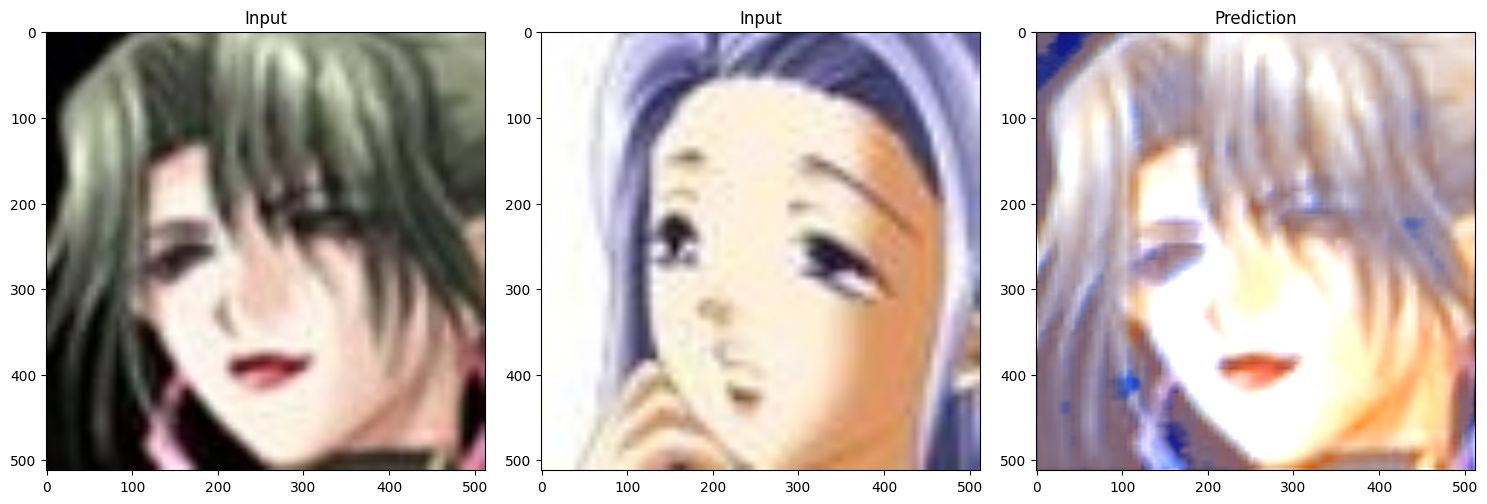

In [42]:
import matplotlib.pyplot as plt

# Assuming you already have the trained model 'unet'
# Assuming you have the test data stored in 'x_test'



# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_trai1 = cv2.cvtColor(x_train[32], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
x_trai2 = cv2.cvtColor(x_train[77], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai2)
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
pred = cv2.cvtColor(prediction_rescaled[0], cv2.COLOR_BGR2RGB)
plt.imshow(pred)
plt.title('Prediction')

plt.tight_layout()
plt.show()
